<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-information-from-GFF-file" data-toc-modified-id="Get-information-from-GFF-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get information from GFF file</a></span><ul class="toc-item"><li><span><a href="#Convert-GFF-to-Pandas-DataFrame" data-toc-modified-id="Convert-GFF-to-Pandas-DataFrame-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convert GFF to Pandas DataFrame</a></span></li></ul></li><li><span><a href="#KEGG-and-COGs" data-toc-modified-id="KEGG-and-COGs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KEGG and COGs</a></span><ul class="toc-item"><li><span><a href="#Generate-nucleotide-fasta-files-for-CDS" data-toc-modified-id="Generate-nucleotide-fasta-files-for-CDS-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate nucleotide fasta files for CDS</a></span></li><li><span><a href="#Run-EggNOG-Mapper" data-toc-modified-id="Run-EggNOG-Mapper-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run EggNOG Mapper</a></span></li><li><span><a href="#Get-KEGG-attributes" data-toc-modified-id="Get-KEGG-attributes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get KEGG attributes</a></span></li><li><span><a href="#Save-KEGG-information" data-toc-modified-id="Save-KEGG-information-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save KEGG information</a></span></li><li><span><a href="#Save-COGs-to-annotation-dataframe" data-toc-modified-id="Save-COGs-to-annotation-dataframe-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save COGs to annotation dataframe</a></span></li></ul></li><li><span><a href="#Uniprot-ID-mapping" data-toc-modified-id="Uniprot-ID-mapping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Uniprot ID mapping</a></span></li><li><span><a href="#Clean-up-and-save-annotation" data-toc-modified-id="Clean-up-and-save-annotation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean up and save annotation</a></span><ul class="toc-item"><li><span><a href="#Final-statistics" data-toc-modified-id="Final-statistics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Final statistics</a></span></li><li><span><a href="#Fill-missing-values" data-toc-modified-id="Fill-missing-values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Fill missing values</a></span></li></ul></li><li><span><a href="#GO-Annotations" data-toc-modified-id="GO-Annotations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>GO Annotations</a></span></li></ul></div>

In [1]:
import re
import sys
sys.path.append('..')

In [2]:
from pymodulon.gene_util import *
import os
from Bio import SeqIO

In [3]:
org_dir = '..'
kegg_organism_code = 'pst'
seq_dir = '../data/sequence_files'

# Get information from GFF file

## Convert GFF to Pandas DataFrame

In [4]:
annot_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.gff3'):
        gff = os.path.join(seq_dir,filename)
        annot_list.append(gff2pandas(gff))
keep_cols = ['refseq','start','end','strand','gene_name','locus_tag','old_locus_tag','gene_product','ncbi_protein']
DF_annot = pd.concat(annot_list)[keep_cols]
DF_annot = DF_annot.drop_duplicates('locus_tag')
DF_annot.set_index('locus_tag',drop=True,inplace=True)

In [5]:
tpm_file = os.path.join(org_dir,'data','log_tpm.csv')
DF_log_tpm = pd.read_csv(tpm_file,index_col=0)

Check that the genes are the same in the expression dataset as in the annotation dataframe.

In [6]:
# Mismatched genes are listed below
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


# Parse TRN File

In [7]:
DF_TRN = pd.DataFrame(columns=['regulator_old', 'gene_id_old'])

with open(os.path.join(org_dir,'data','trn_regprecise.txt')) as trn_text: 
    lines = trn_text.readlines()
    current_regulator = None
    lines = [line for line in lines if line != '\n']
    for line in lines:
        
        line = line.strip()
        if line[:4] == "# TF":
            tf_id = re.search(r'(PSPTO[A-z0-9]{4,5})', line).group(0)
            current_regulator = tf_id
        elif line[:5] == "# RNA":
            rna_id = line[8:]
            current_regulator = rna_id
        else:
            gene_id = line.split('\t')[1].replace('_', '')
            DF_TRN = DF_TRN.append({'regulator_old': current_regulator, 'gene_id_old': gene_id}, ignore_index=True)

DF_TRN

,regulator_old,gene_id_old
0,PSPTO1158,PSPTO1157
1,PSPTO1158,PSPTO1156
2,PSPTO1158,PSPTO1155
3,PSPTO1158,PSPTO1154
4,PSPTO1158,PSPTO1153
...,...,...
295,PSPTO5504,PSPTO5507
296,PSPTO2792,PSPTO2792
297,PSPTO2792,PSPTO2793
298,PSPTO2792,PSPTO2794


We need to convert the old locus tags used in the RegPrecise TRN into the new locus tags used in our gene annotation and expression data

In [8]:
def prune_old_tag_annot(old_tag):
    if type(old_tag) == str:
        tags = old_tag.split('%2C')
        tag_to_use = None
        for tag in tags:
            if '_' not in tag:
                tag_to_use = tag
                break
    else:
        tag_to_use = None
    return tag_to_use

DF_annot['old_locus_tag_parsed'] = DF_annot['old_locus_tag'].apply(prune_old_tag_annot)

DF_annot_old_tag_known = DF_annot[DF_annot['old_locus_tag_parsed'].notna()]

old_to_new_lookup = dict(zip(DF_annot_old_tag_known['old_locus_tag_parsed'], DF_annot_old_tag_known.index))

In [9]:
def regulator_old_to_new(old_reg):
    if 'PSPTO' in old_reg:
        return old_to_new_lookup.get(old_reg)
    else:
        return old_reg

DF_TRN['regulator'] = DF_TRN['regulator_old'].apply(regulator_old_to_new)
DF_TRN['gene_id'] = DF_TRN['gene_id_old'].apply(lambda old_id: old_to_new_lookup.get(old_id))
DF_TRN.head()

,regulator_old,gene_id_old,regulator,gene_id
0,PSPTO1158,PSPTO1157,PSPTO_RS06115,PSPTO_RS06110
1,PSPTO1158,PSPTO1156,PSPTO_RS06115,PSPTO_RS06105
2,PSPTO1158,PSPTO1155,PSPTO_RS06115,PSPTO_RS06100
3,PSPTO1158,PSPTO1154,PSPTO_RS06115,PSPTO_RS06095
4,PSPTO1158,PSPTO1153,PSPTO_RS06115,PSPTO_RS06090


In [10]:
DF_TRN[(DF_TRN['regulator'].isna()) | (DF_TRN['gene_id'].isna())]

,regulator_old,gene_id_old,regulator,gene_id


In [11]:
DF_TRN.to_csv(os.path.join(org_dir,'data','TRN.csv'))

# KEGG and COGs

## Generate nucleotide fasta files for CDS

In [12]:
cds_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.fasta'):
        fasta = os.path.join(seq_dir,filename)
        seq = SeqIO.read(fasta,'fasta')
        
        # Get gene information for genes in this fasta file
        df_genes = DF_annot[DF_annot.refseq == seq.id]
        for i,row in df_genes.iterrows():
            cds = seq[row.start-1:row.end]
            if row.strand == '-':
                cds = seq[row.start-1:row.end].reverse_complement()
            cds.id = row.name
            cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
            cds_list.append(cds)

In [13]:
SeqIO.write(cds_list,os.path.join(seq_dir,'CDS.fna'),'fasta')

5906

## Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file to `<org_dir>/data/eggNOG.annotations`

## Get KEGG attributes

In [14]:
DF_eggnog = pd.read_csv(os.path.join(org_dir,'data','eggNOG.annotations'),sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

In [15]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
2891,PSPTO_RS29195,KEGG_pathway,map02026
2894,PSPTO_RS00005,KEGG_pathway,map02020
2895,PSPTO_RS00005,KEGG_pathway,map04112
2902,PSPTO_RS00010,KEGG_pathway,map00230
2903,PSPTO_RS00010,KEGG_pathway,map00240


## Save KEGG information

In [16]:
DF_kegg.to_csv(os.path.join(org_dir,'data','kegg_mapping.csv'))

## Save COGs to annotation dataframe

In [17]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

# Uniprot ID mapping

In [18]:
# Try the uniprot ID mapping tool - Use EMBL for Genbank file and P_REFSEQ_AC for Refseq file
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')

# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
assert(len(DF_annot) == len(DF_annot))

In [19]:
DF_annot.head()

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,old_locus_tag_parsed,COG,uniprot
locus_tag,,,,,,,,,,,
PSPTO_RS29075,NC_004632.1,350,1660,+,None,NaN,replication protein A,None,None,K,NaN
PSPTO_RS29080,NC_004632.1,1841,3070,-,None,PSPTO_B0002%2CPSPTOB0002,IS91 family transposase,WP_004667395.1,PSPTOB0002,L,Q877Q5
PSPTO_RS29085,NC_004632.1,3277,3750,+,None,PSPTO_B0003%2CPSPTOB0003,DUF3757 domain-containing protein,WP_011102937.1,PSPTOB0003,S,A0A0N8T433
PSPTO_RS29090,NC_004632.1,3813,3938,-,None,NaN,IS91 family transposase,None,None,L,NaN
PSPTO_RS29095,NC_004632.1,4424,6106,-,None,PSPTO_B0005%2CPSPTOB0005,acid phosphatase,WP_011106957.1,PSPTOB0005,M,A0A0P9TTF4


# Clean up and save annotation

In [20]:
# Temporarily remove warning
pd.set_option('mode.chained_assignment', None)

In [21]:
# Reorder annotation file
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','old_locus_tag','start','end','strand','gene_product','COG','uniprot']
else:
    order = ['gene_name','start','end','strand','gene_product','COG','uniprot']
    
DF_annot = DF_annot[order]

In [22]:
DF_annot.head()

,gene_name,old_locus_tag,start,end,strand,gene_product,COG,uniprot
locus_tag,,,,,,,,
PSPTO_RS29075,None,NaN,350,1660,+,replication protein A,K,NaN
PSPTO_RS29080,None,PSPTO_B0002%2CPSPTOB0002,1841,3070,-,IS91 family transposase,L,Q877Q5
PSPTO_RS29085,None,PSPTO_B0003%2CPSPTOB0003,3277,3750,+,DUF3757 domain-containing protein,S,A0A0N8T433
PSPTO_RS29090,None,NaN,3813,3938,-,IS91 family transposase,L,NaN
PSPTO_RS29095,None,PSPTO_B0005%2CPSPTOB0005,4424,6106,-,acid phosphatase,M,A0A0P9TTF4


## Final statistics

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
sns.set_style('ticks')

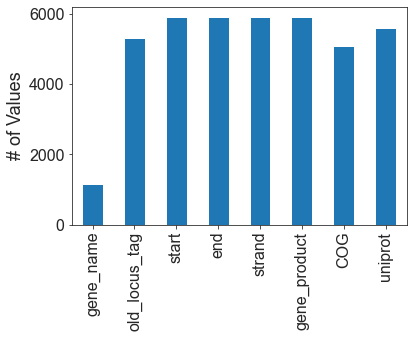

In [25]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

In [26]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

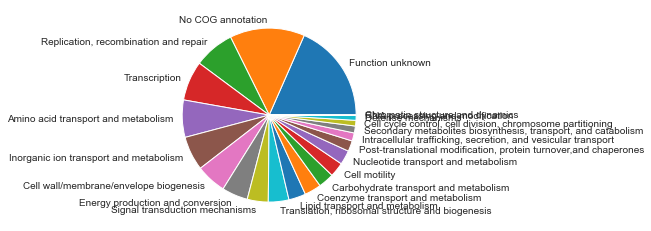

In [27]:
counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

In [28]:
DF_annot.to_csv(os.path.join(org_dir,'data','gene_info.csv'))

# GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2
1. Go to http://amigo.geneontology.org/amigo/search/annotation
1. Filter for your organism
1. Click `CustomDL`
1. Drag `GO class (direct)` to the end of your Selected Fields
1. Save as `GO_annotations.txt` in the `data` folder of your organism directory

In [29]:
DF_GO = pd.read_csv(os.path.join(org_dir,'data','GO_annotations.txt'),sep='\t',header=None,usecols=[2,10,17])
DF_GO.columns = ['gene_name','gene_id','gene_ontology']
DF_GO.gene_id.fillna(DF_GO.gene_name,inplace=True)
DF_GO = DF_GO[['gene_id','gene_ontology']]
DF_GO.head()

,gene_id,gene_ontology
0,PSPTO_2656,molecular_function
1,PSPTO_2656,biological_process
2,PSPTO_3396,structural molecule activity
3,PSPTO_3396,viral process
4,PSPTO_2726,molecular_function


Take a look at the `gene_id` column:
1. Make sure there are no null entries
2. Check if it uses the new or old locus tag (if applicable)

In [46]:
DF_GO = DF_GO[~DF_GO['gene_id'].str.contains('\|')]

In [49]:
# Uncomment this code to replace old locus tag with new locus tag

old_to_new_lookup_underscore = {f'{k[:5]}_{k[5:]}': v for k, v in old_to_new_lookup.items()}
DF_GO.gene_id = DF_GO.gene_id.apply(lambda x: old_to_new_lookup_underscore.get(x))

In [51]:
DF_GO = DF_GO[~DF_GO.gene_id.isnull()]

In [52]:
DF_GO.head()

,gene_id,gene_ontology
0,PSPTO_RS13735,molecular_function
1,PSPTO_RS13735,biological_process
2,PSPTO_RS17555,structural molecule activity
3,PSPTO_RS17555,viral process
4,PSPTO_RS14095,molecular_function


In [53]:
DF_GO[['gene_id','gene_ontology']].to_csv(os.path.join(org_dir,'data','GO_annotations.csv'))